In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import mplfinance as mpf
%matplotlib notebook

In [272]:
my_color = mpf.make_marketcolors(up='r',
                                 down='g',
                                 edge='inherit',
                                 wick='inherit',
                                 volume='inherit')
# 设置图表的背景色
my_style = mpf.make_mpf_style(marketcolors=my_color,
                              figcolor='(0.82, 0.83, 0.85)',
                              gridcolor='(0.82, 0.83, 0.85)')

small_num_font = {'fontname': 'Arial',
                    'size':     '8',
                    'color':    'black',
                    'weight':   'bold',
                    'va':       'bottom'}
normal_label_font = {'fontname': 'pingfang HK',
                     'size':     '8',
                     'color':    'black',
                     'weight':   'normal',
                     'va':       'bottom',
                     'ha':       'right'}


class InterCandle:
    def __init__(self, date, style):
        self.pressed = False
        self.xpress = None

        # 初始化交互式K线图对象，历史数据作为唯一的参数用于初始化对象
        
        file_name = "/root/program_trading/data/taobao_TSLA/{}.csv".format(date)
        self.data = pd.read_csv(file_name, index_col=0, parse_dates=True)
        self.data = self.data.reindex(index=self.data.index[::-1])
        
              
        
        self.style = style
        # 设置初始化的K线图显示区间起点为0，即显示第0到第99个交易日的数据（前100个数据）
        self.idx_start = 0
        self.idx_range = 80
        # 设置ax1图表中显示的均线类型
        self.avg_type = 'ma'
        
        # 初始化figure对象，在figure上建立三个Axes对象并分别设置好它们的位置和基本属性
        self.fig = mpf.figure(style=my_style, facecolor=(0.82, 0.83, 0.85))
        fig = self.fig
        self.ax1 = fig.add_axes([0.08, 0.25, 0.88, 0.60])
        self.ax2 = fig.add_axes([0.08, 0.15, 0.88, 0.10], sharex=self.ax1)
        self.ax2.set_ylabel('volume')
        
        self.t11 = fig.text(0.10, 0.97, 'open:', **normal_label_font)
        self.t1 = fig.text(0.12, 0.97, f'', **small_num_font)
        self.t22 = fig.text(0.10, 0.94, 'high:', **normal_label_font)
        self.t2 = fig.text(0.12, 0.94, f'', **small_num_font)
        self.t33 = fig.text(0.10, 0.91, 'low:', **normal_label_font)
        self.t3 = fig.text(0.12, 0.91, f'', **small_num_font)
        self.t44 = fig.text(0.10, 0.88, 'close:', **normal_label_font)
        self.t4 = fig.text(0.12, 0.88, f'', **small_num_font)
        self.t55 = fig.text(0.30, 0.97, 'dollar:', **normal_label_font)
        self.t5 = fig.text(0.35, 0.97, f'', **small_num_font)
        self.t66 = fig.text(0.30, 0.94, 'percent:', **normal_label_font)
        self.t6 = fig.text(0.35, 0.94, f'', **small_num_font)
        
        self.t_time1 = fig.text(0.30, 0.90, 'time:', **normal_label_font)
        self.t_time2 = fig.text(0.35, 0.90, f'111', **small_num_font)


        
        fig.canvas.mpl_connect('button_press_event', self.on_press)
        #fig.canvas.mpl_connect('button_release_event', self.on_release)
        #fig.canvas.mpl_connect('motion_notify_event', self.on_motion)



    def refresh_plot(self, idx_start, idx_range):
        idx_start = round(idx_start)
        all_data = self.data
        plot_data = all_data.iloc[idx_start: idx_start + idx_range]

        ap = []


        # 绘制图表
        mpf.plot(plot_data,
                 ax=self.ax1,
                 volume=self.ax2,
                 addplot=ap,
                 type='candle',
                 style=self.style,
                 xrotation=0)
        self.fig.show()
        
    def refresh_texts(self, idx):
        idx = round(idx)
        this_data = self.data.iloc[idx]
        last_data = self.data.iloc[idx-1]
        
        self.t1.set_text(f'{np.round(this_data["open"], 3)}')
        self.t2.set_text(f'{np.round(this_data["high"], 3)}')
        self.t3.set_text(f'{np.round(this_data["low"], 3)}')
        self.t4.set_text(f'{np.round(this_data["close"], 3)}')
        self.t5.set_text(f'{np.round(this_data["close"]-last_data["close"], 3)}')
        self.t6.set_text('{:.2%}'.format(this_data["close"]/last_data["close"]-1))
        
        self.t_time2.set_text(self.data.index[idx])

        self.t1.set_color(self.get_color(this_data['open'], last_data['close']))
        self.t2.set_color(self.get_color(this_data['high'], last_data['close']))
        self.t3.set_color(self.get_color(this_data['low'], last_data['close']))
        self.t4.set_color(self.get_color(this_data['close'], last_data['close']))
        self.t5.set_color(self.get_color(this_data['close'], last_data['close']))
        self.t6.set_color(self.get_color(this_data['close'], last_data['close']))
        

    def get_color(self, this_data, last_data):
        if this_data - last_data > 0:
            return 'red'
        elif this_data - last_data < 0:
            return 'green'
        else:
            return 'black'
    

    def on_press(self, event):
        if not event.inaxes == self.ax1:
            return
        if event.button != 1 and event.button != 3:
            return

        self.xpress = event.xdata

        if event.button == 1:  #left
            #self.pressed = True
        
            self.ax1.clear()
            self.ax2.clear()
            self.refresh_plot(self.xpress-20, 40)
            self.refresh_texts(self.xpress)
        elif event.button == 3: #middle
            self.ax1.clear()
            self.ax2.clear()
            self.refresh_plot(0, 10)
            self.refresh_texts(self.xpress)
        else :  #right
            self.ax1.clear()
            self.ax2.clear()
            self.refresh_plot(self.xpress, 30)
            self.refresh_texts(self.xpress)

        
        #if event.button ==3:
        #    #self.ax1.clear()
        #    self.ax2.clear()
        #    #self.refresh_plot(self.xpress, self.idx_range)
        #    self.refresh_texts(self.xpress)
        
    def on_motion(self, event):
        if not self.pressed:
            return

        if not event.inaxes == self.ax1:
            return

        dx = event.xdata - self.xpress

        new_start = self.idx_start - dx
        
        if new_start <= 0:
            new_start = 0
        if new_start >= len(self.data) - self.idx_range:
            new_start = len(self.data) - self.idx_range


        self.ax1.clear()
        self.ax2.clear()

        self.refresh_texts(new_start, self.idx_range)
        self.refresh_plot(new_start)

    def on_release(self, event):
        self.pressed = False
        dx = event.xdata - self.xpress
        self.idx_start -= dx
        if self.idx_start <= 0:
            self.idx_start = 0
        if self.idx_start >= len(self.data) - self.idx_range:
            self.idx_start = len(self.data) - self.idx_range


<IPython.core.display.Javascript object>


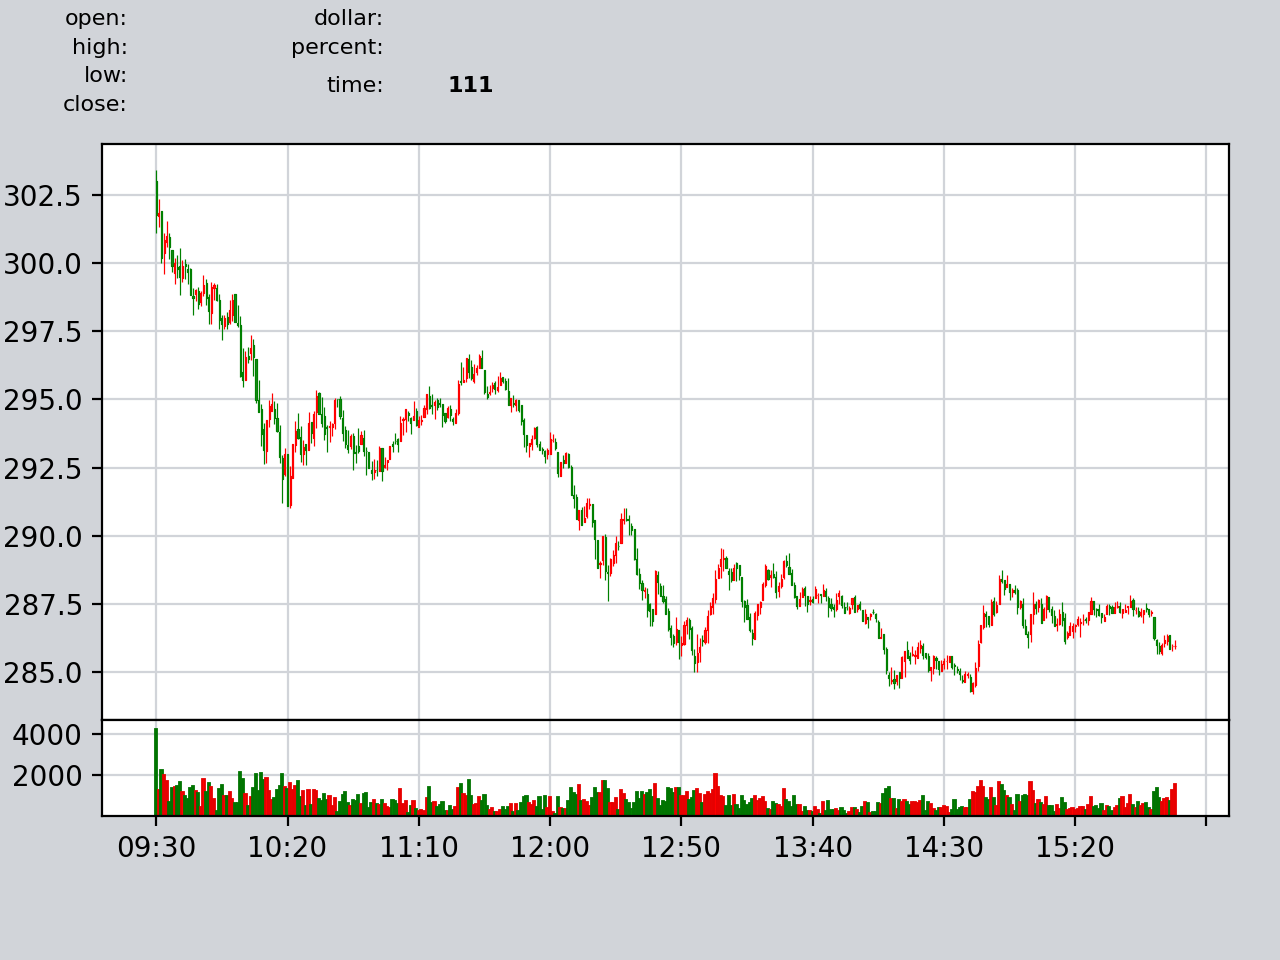

In [279]:
candle = InterCandle(date='2020-07-31', style=my_style)
candle.refresh_plot(0, -1)

<IPython.core.display.Javascript object>


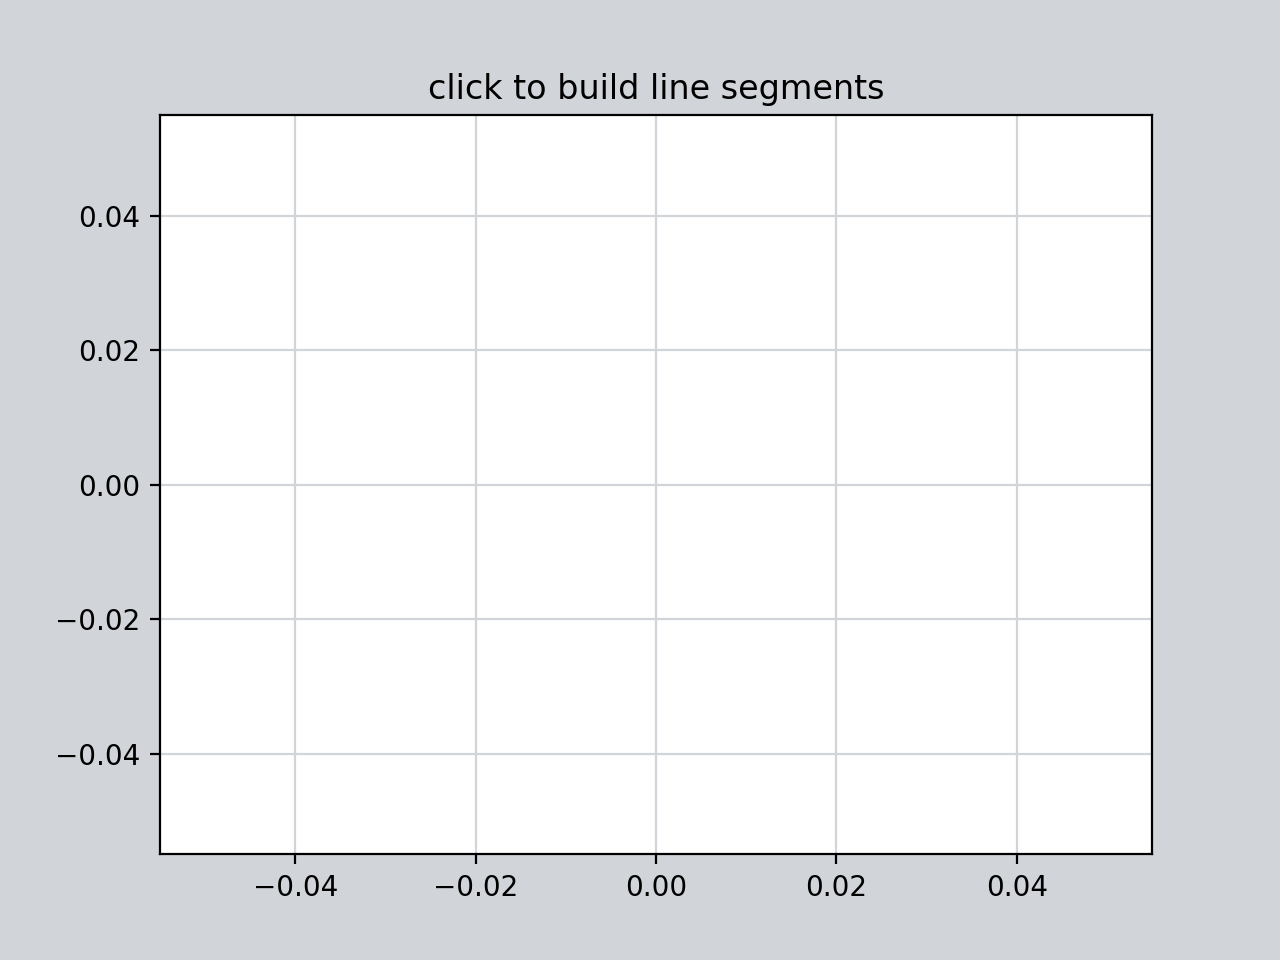

In [268]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([0], [0])  # empty line
linebuilder = LineBuilder(line)

plt.show()